In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector

In [2]:
#connecting mysql to my database
cnx = mysql.connector.connect(user='root',
                              host='localhost', password ='Shreya@1994',
                              database='data_silso_histo_duplicate', auth_plugin='mysql_native_password')

In [3]:
query = "SELECT * FROM data WHERE DATE BETWEEN '1859-01-01' AND '1863-01-30'"
df_mysql = pd.read_sql(query,con = cnx)
data = pd.DataFrame(df_mysql)

In [4]:
query = "SELECT * FROM observers"
df_mysql = pd.read_sql(query,con = cnx)
data1 = pd.DataFrame(df_mysql)

In [5]:
#renaming the column ID for easy merging
data1.rename(columns={'ID':'FK_OBSERVERS'},inplace=True)

In [6]:
df1 = pd.merge(data,data1, on ='FK_OBSERVERS')

In [7]:
#converting the data types
df1 = df1.astype({"FK_OBSERVERS": float,"WOLF": float})

In [8]:
df1.rename(columns={'DATE':'Date'},inplace=True)
df1 = df1.sort_values('Date')

In [9]:
df1.Date = pd.to_datetime(df1['Date'])

In [10]:
#creating a dictionary for each observer based on their ID
dd = dict(tuple(df1.groupby('FK_OBSERVERS')))

In [11]:
#making a ist of all the observers
obs1 = np.array(list(dd.keys()))

In [12]:
obs1 #ID's of all the observer present

array([ 2.,  3., 17., 23., 29., 30., 31., 33., 34., 35., 36.])

In [13]:
#creating a dataframe to hold all the observers data in each column
mer = pd.DataFrame(columns = ['Date'])
i=0
for i in range(len(obs1)):
   # print(obs1[i])
    b = dd[obs1[i]]
    b = pd.DataFrame(b)
    alias = b.ALIAS.iloc[0]
    temp = pd.DataFrame()
    
    temp["Date"] = b.Date
    temp[alias] = b.WOLF
    mer  = pd.merge(temp,mer, on="Date", how= 'outer')
   

In [14]:
mer.head() #this dataframe contains all the observers data as columns

,Date,Carrington,Heis,Schott,Spörer,Franzenau,Airy,Jenzer,Schmidt,Schwabe,WOLF - P - M,WOLF - S - M
0,1859-01-02,2152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0
1,1859-01-02,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0
2,1859-01-09,2679.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0
3,1859-01-09,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0
4,1859-01-14,2808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0


In [15]:
df = mer #creating a temporary dataframe to work on without altering the original dataframe

In [16]:
df = pd.read_csv(r'C:\Users\ShreyaB\Documents\Mitteilungen\data\median_example.csv') #example dataset, comment it in case using the above process

In [17]:
df= df.set_index('Date') #setting the date as index

In [18]:
df.head()

,wolf,SN
Date,,
1825-11-05,NaN,11.0
1825-11-08,NaN,11.0
1825-11-09,NaN,11.0
1825-11-10,NaN,11.0
1825-11-11,NaN,11.0


In [19]:
def compute_k_Median(df):
    #intitalising few values
    reject = 0
    j=0
    Catalog_info = pd.DataFrame() #all the k-factor information will be stored here
    while(reject == 0):
        #print(reject)
        j=j+1
        observers = df.columns
        #condition to select only the observers name useful for next iterations
        observers_1 = [col for col in observers if not (col.startswith('k_') or col == 'Median' or col == 'Std')]
        #print(observers_1)
        
        #calculate the median
        df["Median"] = df[observers_1].mean(axis=1,skipna=True)
        df_temp =pd.DataFrame(index = [j])
        #calculate k_factors for each observer
        for observer in observers_1:
            df["k_" + observer] = df["Median"] / df[observer]
            df["k_" + observer]= df["k_" + observer].replace([np.inf, -np.inf], np.nan)
            df["k_" + observer] = df["k_" + observer].mean(axis=0)
            df_temp[observer] = df["k_" + observer].iloc[0]
        Catalog_info=Catalog_info.append(df_temp) #storing the iteration number and k value for each observer
        #print(df)

        for observer in observers_1: #multiplying the observers with their respective k-factors
            df[observer] = df[observer] * df["k_" + observer]
        #print(df)
        df["k_Median"] = df[observers_1].median(axis=1,skipna=True)
        df["Std"] = df[observers_1].std(axis=1,skipna=True)
        df["k_Upper"] = df.k_Median + df.Std #setting the upper and lower bounds
        df["k_Lower"] = df.k_Median - df.Std
        #print(df)
        reject =1 #updating the condition unless proved otherwise
        final_df = pd.DataFrame()
        final_df["Date"] = df.index
        final_df["Median"] = df["k_Median"].values
        #print(final_df)
        for idx, row in df.iterrows():
            #print(idx)
            #print(row)
         # Check if the value is within the specified range
            for col in df[observers_1]:
                #print(row[col],row['k_Lower'],row['k_Upper'])
                # Check conditions for each value in the row
                if row[col] < row['k_Lower'] or row[col] > row['k_Upper']:
                    df.at[idx, col] = np.nan

                    reject=0 # If any value is out of range, set rejection flag
        
        return final_df, Catalog_info
    

In [20]:
final_df, Catalog_info = compute_k_Median(df)

In [21]:
 Catalog_info #for k-factors and number of iterations

,wolf,SN
1,0.998235,1.008053


In [22]:
final_df.head() #final median

,Date,Median
0,1825-11-05,11.088578
1,1825-11-08,11.088578
2,1825-11-09,11.088578
3,1825-11-10,11.088578
4,1825-11-11,11.088578


In [23]:
final_df.Date = pd.to_datetime(final_df.Date)
final_df = final_df.sort_values("Date")

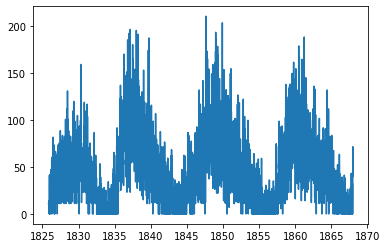

In [24]:
plt.plot(final_df.Date, final_df.Median)